# Audio loading, Processing and Feature Extraction

This tutorial covers the essential steps of handling audio data for speech recognition tasks. We will go through loading audio files, pre-processing them, and extracting relevant features using PyTorch and other supportive libraries.

## 1. Loading Audio Data

Loading audio data is the first step in any speech recognition pipeline. Audio files can be stored in various formats (e.g., WAV, MP3, FLAC) and must be converted into a numerical format that can be processed by ASR algorithms. This typically involves converting the audio into a time-series representation where the amplitude of the audio signal is sampled at regular intervals. Loading audio correctly is crucial for maintaining the integrity of the data. Errors in loading can introduce noise or distortions that may adversely affect the ASR's performance. Additionally, understanding the sampling rate and the duration of the audio provides valuable information for subsequent processing stages such as feature extraction.

In [ ]:
!pip install librosa

In [ ]:
# on colab, run this to download data
!gdown -O ./data --folder https://drive.google.com/drive/folders/18fk-FTvEGQhGyhNTawIw2lQAVfkL6y2I

#### Using Librosa

In [ ]:
import librosa
import IPython.display as ipd

# Load an audio file as a floating point time series
audio_path = 'data/example.mp3'
audio_data, sampling_rate = librosa.load(audio_path, sr=None)  # sr=None ensures original sampling rate is preserved

# Display basic information about the audio
print(f"Audio duration: {audio_data.shape[0] / sampling_rate:.2f} seconds")
print(f"Sampling rate: {sampling_rate} Hz")

Audio duration: 38.91 seconds
Sampling rate: 44100 Hz


#### Using PyTorch

In [ ]:
import torch
import torchaudio
import matplotlib.pyplot as plt

def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    print(f"Loaded audio file '{file_path}'")
    print(f"Sample rate: {sample_rate}")
    print(f"Waveform tensor shape: {waveform.shape}")
    return waveform, sample_rate

# Example usage
audio_path = file_path = 'data/example.mp3'
waveform, sample_rate = load_audio(audio_path)


Loaded audio file 'data/example.mp3'
Sample rate: 44100
Waveform tensor shape: torch.Size([1, 1715918])


Sampling is the process of recording the amplitude of a sound wave at discrete intervals. The sample rate defines how many samples per second are recorded.
The choice of sample rate affects the accuracy of the speech features captured. A higher sample rate can capture more detail but requires more computational resources.


Being able to play audio data from within your Python environment is essential for manual inspection and auditory verification of the audio used in speech recognition tasks.

In [ ]:
# Play the loaded audio file
ipd.Audio(waveform, rate=sampling_rate)


Output hidden; open in https://colab.research.google.com to view.

### Visualizing Audio Data

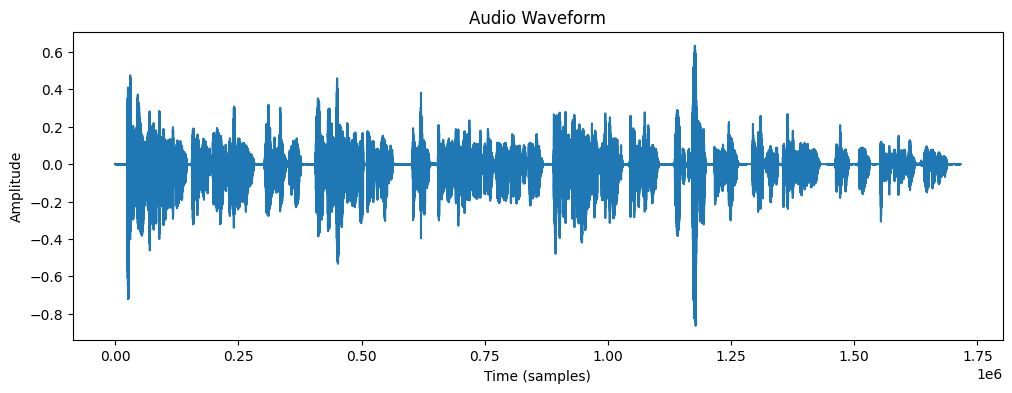

In [ ]:
import matplotlib.pyplot as plt

# Plotting the waveform
plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title('Audio Waveform')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()


## 2. Audio Pre-processing

Speech recognition systems often require specific audio preprocessing steps to improve the accuracy of recognition. Common steps include:
- Resampling: Changing the sample rate of the audio file. This is often necessary to standardize the input data to a consistent format expected by downstream processes or models.
- Normalization: Scaling the audio waveform so that the amplitude ranges within a specific interval, typically between -1 and 1. This helps in reducing disparities in volume and amplitude between different audio recordings

In [ ]:
def preprocess_audio(waveform, new_sample_rate=16000):
    # Resample
    if waveform.shape[1] != new_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
        waveform = resampler(waveform)
        print(f"Resampled waveform to {new_sample_rate} Hz")

    # Normalize audio to [-1, 1]
    waveform = waveform / torch.max(torch.abs(waveform))
    return waveform

waveform = preprocess_audio(waveform, new_sample_rate=16000)


Resampled waveform to 16000 Hz


Pre-processing standardizes the audio inputs, which helps in reducing variability that is not related to the linguistic content of the speech. For example, models trained with data at a consistent sample rate and amplitude are more stable and perform better in recognizing speech from various sources.

## 3. Feature Extraction

Feature extraction is a crucial step in speech recognition. It transforms raw audio data into a more compact and representative format that is easier for ASR models to process. There are several features commonly used:

- **Spectrograms**: A spectrogram is a visual representation of the spectrum of frequencies in a sound as they vary with time. It is obtained by applying a Fourier transform (FFT) across short time windows of the waveform.

- **Mel Spectrograms**: This involves converting the frequency scale of the spectrogram to the Mel scale, which more closely approximates human auditory perception's response to different frequencies. The frequencies are spaced evenly according to the Mel scale, which is a perceptual scale of pitches judged by listeners to be equal in distance from one another.

- Mel-frequency cepstral coefficients (**MFCCs**): MFCCs are perhaps the most widely used feature extraction method in speech recognition systems. They are derived from the logarithm of the Mel spectrogram followed by a discrete cosine transform (DCT). They provide a compact representation of the audio based on the power spectrum of a signal.

**Role of `n_mfcc`**

- `n_mfcc` Parameter: This parameter specifies how many of the resulting cepstral coefficients are returned after the DCT. The first coefficient, which represents the mean energy of the signal, is usually discarded because it carries less information about the spectral shape.
- Choosing `n_mfcc`: The number of coefficients to use is a trade-off between having enough coefficients to capture the important characteristics of the audio signal and not having so many that the dimensionality becomes too high, which could lead to overfitting in machine learning models. Typically, 12 to 20 MFCCs are used in speech recognition tasks.
- In the above code `n_mfcc` was set to 13. This means the MFCC computation process will extract the first 13 coefficients for each frame


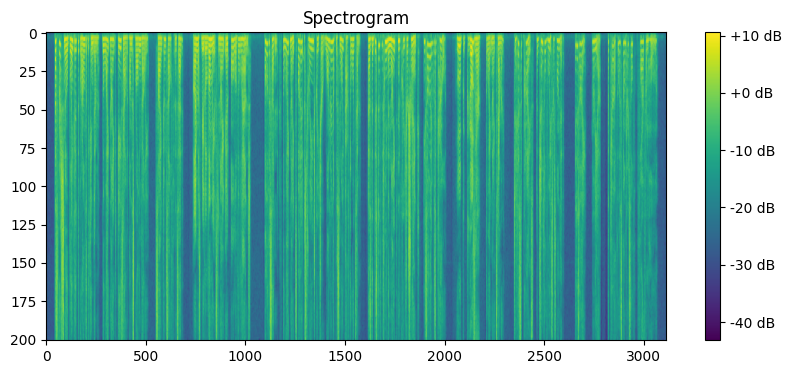

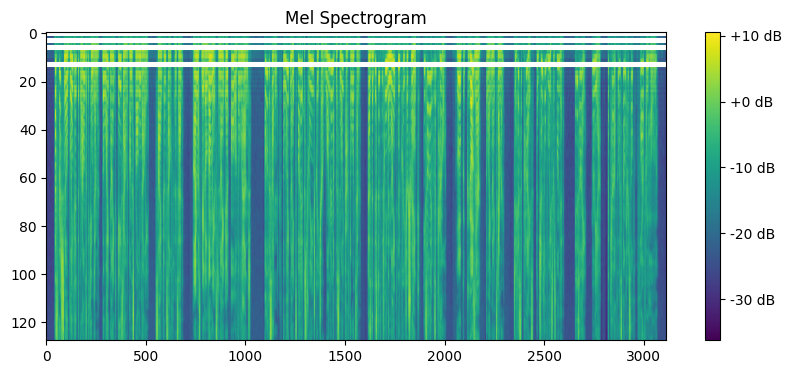

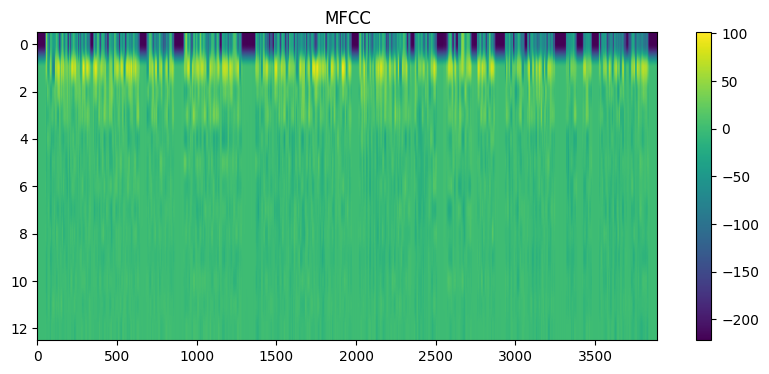

In [ ]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T

def extract_features(waveform, sample_rate, n_mfcc=13):
    # Compute standard Spectrogram
    spectrogram_transform = T.Spectrogram()
    spectrogram = spectrogram_transform(waveform)

    # Compute Mel Spectrogram
    mel_spectrogram_transform = T.MelSpectrogram(sample_rate=sample_rate)
    mel_spectrogram = mel_spectrogram_transform(waveform)

    # Compute MFCCs from Mel Spectrogram
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 23})
    mfccs = mfcc_transform(waveform)

    return spectrogram, mel_spectrogram, mfccs

# Example usage (assuming 'waveform' and 'sample_rate' are already defined)
spectrogram, mel_spectrogram, mfccs = extract_features(waveform, sample_rate=16000)

# Plot the standard Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram.log2()[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the Mel Spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram.log2()[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the MFCCs
plt.figure(figsize=(10, 4))
plt.imshow(mfccs[0,:,:].detach().numpy(), cmap='viridis', aspect='auto')
plt.title('MFCC')
plt.colorbar()
plt.show()


**Importance for ASR:**

These features are crucial because they transform the audio into a form that emphasizes characteristics important for distinguishing between different phonemes (sounds) in speech. This transformation is beneficial because:

**Spectrograms** provide a time-frequency representation, capturing when certain sounds occur and their frequencies, which are essential cues for understanding speech.

**Mel Spectrograms** emphasize perceptually important frequencies, making it easier for the model to focus on parts of the audio that are more likely to carry linguistic content.

**MFCCs** capture the timbral and envelope characteristics of sound. They emphazie aspects of sound as perceived by the human ear. They are widely used in ASR because they effectively represent the vocal tract configuration that determines how we pronounce sounds, thus capturing the linguistic content effectively.